# Predicting Medical Appointment No Shows

Dataset: https://www.kaggle.com/joniarroba/noshowappointments

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import os, sys
import itertools
import numpy as np
import pandas as pd

## Load dataset

This dataset is used to predict **No-show** from various factors recorded.

In [3]:
# Dataset location
DATASET = '/dsa/data/all_datasets/AppliedML_M6/appointment_noshow.csv'
assert os.path.exists(DATASET)

# Load and shuffle
dataset = pd.read_csv(DATASET).sample(frac = 1).reset_index(drop=True)
dataset.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


## Processing

List top 5 records to have a preview of this dataset.

In [4]:
dataset.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,5.257126e+14,5700902,F,2016-05-16T09:53:31Z,2016-05-25T00:00:00Z,25,RESISTÊNCIA,0,0,0,0,0,1,No
1,3.531679e+14,5586790,F,2016-04-15T07:58:18Z,2016-05-03T00:00:00Z,56,CARATOÍRA,0,0,0,0,0,1,No
2,5.445588e+12,5635879,M,2016-04-28T14:14:13Z,2016-05-12T00:00:00Z,15,GURIGICA,0,0,0,0,0,0,No
3,8.296685e+11,5673939,F,2016-05-09T10:07:58Z,2016-05-09T00:00:00Z,1,ENSEADA DO SUÁ,0,0,0,0,0,0,No
4,1.119268e+14,5778600,F,2016-06-06T15:55:20Z,2016-06-06T00:00:00Z,70,JARDIM CAMBURI,0,1,1,0,0,0,No


Looks like we won't be using **PatientId** and **AppointmentID** columns.

Delete those columns.

In [5]:
dataset.drop('PatientId', axis=1, inplace=True)
dataset.drop('AppointmentID', axis=1, inplace=True)

dataset.head()

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,F,2016-05-16T09:53:31Z,2016-05-25T00:00:00Z,25,RESISTÊNCIA,0,0,0,0,0,1,No
1,F,2016-04-15T07:58:18Z,2016-05-03T00:00:00Z,56,CARATOÍRA,0,0,0,0,0,1,No
2,M,2016-04-28T14:14:13Z,2016-05-12T00:00:00Z,15,GURIGICA,0,0,0,0,0,0,No
3,F,2016-05-09T10:07:58Z,2016-05-09T00:00:00Z,1,ENSEADA DO SUÁ,0,0,0,0,0,0,No
4,F,2016-06-06T15:55:20Z,2016-06-06T00:00:00Z,70,JARDIM CAMBURI,0,1,1,0,0,0,No


Convert **Gender** and **No-show** to binary (0s and 1s).

In [6]:
dataset['Gender'] = dataset['Gender'].apply(['F', 'M'].index)
dataset['No-show'] = dataset['No-show'].apply(['No', 'Yes'].index)

dataset.head()

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,0,2016-05-16T09:53:31Z,2016-05-25T00:00:00Z,25,RESISTÊNCIA,0,0,0,0,0,1,0
1,0,2016-04-15T07:58:18Z,2016-05-03T00:00:00Z,56,CARATOÍRA,0,0,0,0,0,1,0
2,1,2016-04-28T14:14:13Z,2016-05-12T00:00:00Z,15,GURIGICA,0,0,0,0,0,0,0
3,0,2016-05-09T10:07:58Z,2016-05-09T00:00:00Z,1,ENSEADA DO SUÁ,0,0,0,0,0,0,0
4,0,2016-06-06T15:55:20Z,2016-06-06T00:00:00Z,70,JARDIM CAMBURI,0,1,1,0,0,0,0


Convert **ScheduledDay** and **AppointmentDay** into np.datetime data type.

In [7]:
dataset['ScheduledDay'] = dataset['ScheduledDay'].apply(np.datetime64)
dataset['AppointmentDay'] = dataset['AppointmentDay'].apply(np.datetime64)

dataset.head()

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,0,2016-05-16 09:53:31,2016-05-25,25,RESISTÊNCIA,0,0,0,0,0,1,0
1,0,2016-04-15 07:58:18,2016-05-03,56,CARATOÍRA,0,0,0,0,0,1,0
2,1,2016-04-28 14:14:13,2016-05-12,15,GURIGICA,0,0,0,0,0,0,0
3,0,2016-05-09 10:07:58,2016-05-09,1,ENSEADA DO SUÁ,0,0,0,0,0,0,0
4,0,2016-06-06 15:55:20,2016-06-06,70,JARDIM CAMBURI,0,1,1,0,0,0,0


Add a column **AwaitingTime** filled with the time difference between **AppointmentDay** and **ScheduledDay**,
in number of days.

In [8]:
dataset['AwaitingTime'] = (dataset['AppointmentDay'] - dataset['ScheduledDay']).apply(lambda dt: dt.days)
dataset.head()

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,AwaitingTime
0,0,2016-05-16 09:53:31,2016-05-25,25,RESISTÊNCIA,0,0,0,0,0,1,0,8
1,0,2016-04-15 07:58:18,2016-05-03,56,CARATOÍRA,0,0,0,0,0,1,0,17
2,1,2016-04-28 14:14:13,2016-05-12,15,GURIGICA,0,0,0,0,0,0,0,13
3,0,2016-05-09 10:07:58,2016-05-09,1,ENSEADA DO SUÁ,0,0,0,0,0,0,0,-1
4,0,2016-06-06 15:55:20,2016-06-06,70,JARDIM CAMBURI,0,1,1,0,0,0,0,-1


Check unique values of all columns, except **ScheduledDay** and **AppointmentDay**
because they would have too many unique values.

The goal is to understand whether there's missing values or "bad" values in the dataset.

In [9]:
for column_name in set(dataset.columns)-{'ScheduledDay', 'AppointmentDay'}:
    print(column_name, sorted(np.unique(dataset['AwaitingTime'])))


Age [-7, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 100, 101, 102, 103, 104, 106, 107, 108, 109, 110, 111, 114, 116, 118, 121, 122, 124, 125, 126, 131, 132, 138, 141, 145, 150, 154, 161, 168, 175, 178]
Neighbourhood [-7, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 100, 101, 102, 103, 104, 106, 107, 108, 10

### Outliers

Now we'll import some outlier detection utilities.

In [10]:
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

First thing we noticed is that age can't be less than or equal to 0 unless there's probably some discrepancy in the dataset. We remove those rows.

In [11]:
dataset = dataset[dataset.Age >=1]

dataset = dataset.reset_index(drop=True)

print('Number of records', len(dataset))
print('Age', np.unique(dataset['Age']))

Number of records 106987
Age [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 102 115]


Remove outliers in **AwaitingTime** with **Elliptic Envelope**.

In [12]:
awaiting_time = np.array(dataset['AwaitingTime']).reshape((-1, 1))

envelope = EllipticEnvelope(contamination = 0.003)
envelope.fit(awaiting_time)

outliers = envelope.predict(awaiting_time)==-1
dataset.drop(np.flatnonzero(outliers), inplace=True)
dataset.reset_index(drop=True, inplace=True)
# ----------------------------------

print({'inliers': np.sum(~outliers), 'outliers': np.sum(outliers)})
print('Number of records', len(dataset))
print('AwaitingTime', np.unique(dataset['AwaitingTime']))

{'outliers': 317, 'inliers': 106670}
Number of records 106670
AwaitingTime [-7 -2 -1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21
 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85]


In [13]:
print(~outliers)
print(np.sum(~outliers))
print(np.sum(outliers))
np.unique(dataset['AwaitingTime'])

[ True  True  True ...,  True  True  True]
106670
317


array([-7, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,
       14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
       31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
       48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
       65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
       82, 83, 84, 85])

In [14]:
print(outliers)

[False False False ..., False False False]


In [15]:
print({'inliers': np.sum(~outliers), 'outliers': np.sum(outliers)})
print('Number of records', len(dataset))
print('AwaitingTime', np.unique(dataset['AwaitingTime']))

{'outliers': 317, 'inliers': 106670}
Number of records 106670
AwaitingTime [-7 -2 -1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21
 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85]


### Encoding

Dates and times are usually difficult to deal with for predictive models as input data.

Therefore, we create take day and month out of **AppointmentDay** and **create two new columns** respectively.

Also remove **ScheduledDay** because it can be derived from these two columns and **AwaitingTime**,
so this column would become redundant.

Remove column **AppointmentDay**.

In [16]:
dataset['AppointmentDate_day'] = dataset['AppointmentDay'].apply(lambda d: d.day)
dataset['AppointmentDate_month'] = dataset['AppointmentDay'].apply(lambda d: d.month)

dataset.drop('ScheduledDay', axis=1, inplace=True)
dataset.drop('AppointmentDay', axis=1, inplace=True)

dataset.head()

,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,AwaitingTime,AppointmentDate_day,AppointmentDate_month
0,0,25,RESISTÊNCIA,0,0,0,0,0,1,0,8,25,5
1,0,56,CARATOÍRA,0,0,0,0,0,1,0,17,3,5
2,1,15,GURIGICA,0,0,0,0,0,0,0,13,12,5
3,0,1,ENSEADA DO SUÁ,0,0,0,0,0,0,0,-1,9,5
4,0,70,JARDIM CAMBURI,0,1,1,0,0,0,0,-1,6,6


Strings are also undesirable data types here. We use **LabelBinarizer** to create a one-hot encoding for **Neighbourhood** instead.

In [17]:
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
Neighbourhood_onehot = encoder.fit_transform(dataset['Neighbourhood'])
# ----------------------------------

for j, neighborhood in enumerate(encoder.classes_):
    dataset['Neighbourhood ({})'.format(neighborhood)] = Neighbourhood_onehot[:, j]

del dataset['Neighbourhood']
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106670 entries, 0 to 106669
Data columns (total 93 columns):
Gender                                         106670 non-null int64
Age                                            106670 non-null int64
Scholarship                                    106670 non-null int64
Hipertension                                   106670 non-null int64
Diabetes                                       106670 non-null int64
Alcoholism                                     106670 non-null int64
Handcap                                        106670 non-null int64
SMS_received                                   106670 non-null int64
No-show                                        106670 non-null int64
AwaitingTime                                   106670 non-null int64
AppointmentDate_day                            106670 non-null int64
AppointmentDate_month                          106670 non-null int64
Neighbourhood (AEROPORTO)                      106670 non-nul

### Statistics

Now all columns are integer type.

Check statictics for the rest of the columns.

In [18]:
dataset.loc[:, [column_name for column_name in dataset.columns
    if not column_name.startswith('Neighbourhood')]].describe()

,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,AwaitingTime,AppointmentDate_day,AppointmentDate_month
count,106670.000000,106670.000000,106670.000000,106670.000000,106670.000000,106670.000000,106670.000000,106670.000000,106670.000000,106670.000000,106670.000000,106670.000000
mean,0.344839,38.248317,0.101191,0.203019,0.074088,0.031452,0.022874,0.322162,0.202447,8.867067,12.469195,5.211278
std,0.475318,22.428750,0.301582,0.402248,0.261916,0.174537,0.163863,0.467307,0.401825,14.165951,9.046689,0.473975
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.000000,1.000000,4.000000
25%,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,5.000000,5.000000
50%,0.000000,38.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,10.000000,5.000000
75%,1.000000,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,13.000000,19.000000,5.000000
max,1.000000,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,85.000000,31.000000,6.000000


Check class balance.

This dataset is used to potentially predict **No-show** from various factors recorded.
Since no-shows should usually be the minority cases, it's very likely that this dataset is imbalanced.

We want to understand how balanced it is between number of positive and negative samples quantitatively.  
So we find out the ratio of no-shows among the entire dataset.

In [19]:
print(dataset['No-show'].head())


0    0
1    0
2    0
3    0
4    0
Name: No-show, dtype: int64


In [20]:
num_noshow = np.sum(dataset['No-show']==1) # find out total number of no-show cases
print('noshow ratio:', num_noshow, '/', len(dataset), '=', num_noshow / len(dataset))

noshow ratio: 21595 / 106670 = 0.202446798538


For the sake of fairness, we will resample no-show cases to rebalance the dataset.

First, we calculate this upsample rate that would make positive and negative samples appear 50/50,
when multiplied to number of no-show cases.

In [21]:
upsample_rate = (len(dataset) - num_noshow) / num_noshow
print('upsample_rate:', upsample_rate)

upsample_rate: 3.93956934476


Verify this upsample rate by definition.

In [22]:
print(int(num_noshow * upsample_rate), len(dataset) - num_noshow)

85075 85075


Now we resample dataset. Please upsample these no-show cases then concatenate with original "show-up" cases and
and create a new dataset **dataset_resampled**.

In [23]:
dataset_resampled = pd.concat([
    dataset[dataset['No-show'] == 1].sample(frac=upsample_rate, replace=True).reset_index(drop=True),
    dataset[dataset['No-show'] == 0]])


Shuffle **dataset_resampled**.

In [24]:
from sklearn.utils import shuffle
dataset_resampled = shuffle(dataset_resampled)

Verify no-show ratio again.

In [25]:
print('noshow ratio:', np.sum(dataset_resampled['No-show'] == 1) / len(dataset_resampled))

noshow ratio: 0.5


To avoid mixing up **dataset** and **dataset_resampled**,
we replace **dataset** and delete **dataset_resampled**.

In [26]:
dataset = dataset_resampled
del dataset_resampled

Next thing, you may realize that we got a lot of columns just for neighborhood.
Number of these columns are way higher than other features combined.
Since we have already made an decision to encode them with one-hot encoding arbitrary,
why not use PCA on these columns and see if we could compress them down.

In [27]:
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.preprocessing import scale, LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif

Select all Neighbourhood columns.

In [28]:
X_neighbors = np.array(dataset.loc[:, [column_name for column_name in dataset
    if column_name.startswith('Neighbourhood')]])
X_neighbors.shape

(170150, 81)

Apply PCA to **X_neighbors** with 60 pincipal components to create **X_neighbors_PCA**.

In [29]:
print(X_neighbors[0:3])

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0]]


In [30]:
print(X_neighbors.shape[1])

81


In [31]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 60)
X_PCA = pca.fit_transform(X_neighbors)

for j in range(X_PCA.shape[1]):
        dataset['PCA{}'.format(j)] = X_PCA[:, j]


Check combined variance explained ratio to make sure it doesn't drop too significantly.

In [32]:
np.sum(pca.explained_variance_ratio_)

0.96910368879762232

In [33]:
dataset.head()

,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,AwaitingTime,...,PCA50,PCA51,PCA52,PCA53,PCA54,PCA55,PCA56,PCA57,PCA58,PCA59
48402,0,34,0,0,0,0,0,0,0,-1,...,-0.005671,-0.002042,-0.000552,-0.005107,-0.001731,-0.002332,0.000938,-0.000337,-0.001324,-0.000254
60410,0,15,0,0,0,0,0,0,1,-1,...,-0.067004,-0.021514,-0.005704,-0.040514,-0.012871,-0.016636,0.006431,-0.002293,-0.008709,-0.001638
72975,1,2,0,0,0,0,0,0,0,-1,...,-0.002701,-0.000979,-0.000265,-0.002492,-0.000849,-0.001147,0.000463,-0.000166,-0.000656,-0.000126
67428,0,9,0,0,0,0,0,0,1,0,...,-0.005625,-0.002026,-0.000548,-0.005067,-0.001718,-0.002315,0.000931,-0.000334,-0.001315,-0.000252
48783,0,68,0,1,1,0,0,0,0,-1,...,-0.011621,-0.004135,-0.001116,-0.009990,-0.003355,-0.004494,0.001795,-0.000644,-0.002519,-0.000481


Now we need to delete or remove all Neighbourhood columns because we are going to replace them all with their principal components.

In [34]:
dataset = dataset.iloc[:, np.r_[0:12, 93:153]] # select columns of interest
dataset.head()

,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,AwaitingTime,...,PCA50,PCA51,PCA52,PCA53,PCA54,PCA55,PCA56,PCA57,PCA58,PCA59
48402,0,34,0,0,0,0,0,0,0,-1,...,-0.005671,-0.002042,-0.000552,-0.005107,-0.001731,-0.002332,0.000938,-0.000337,-0.001324,-0.000254
60410,0,15,0,0,0,0,0,0,1,-1,...,-0.067004,-0.021514,-0.005704,-0.040514,-0.012871,-0.016636,0.006431,-0.002293,-0.008709,-0.001638
72975,1,2,0,0,0,0,0,0,0,-1,...,-0.002701,-0.000979,-0.000265,-0.002492,-0.000849,-0.001147,0.000463,-0.000166,-0.000656,-0.000126
67428,0,9,0,0,0,0,0,0,1,0,...,-0.005625,-0.002026,-0.000548,-0.005067,-0.001718,-0.002315,0.000931,-0.000334,-0.001315,-0.000252
48783,0,68,0,1,1,0,0,0,0,-1,...,-0.011621,-0.004135,-0.001116,-0.009990,-0.003355,-0.004494,0.001795,-0.000644,-0.002519,-0.000481


Attatch principal components of the original Neighbourhood columns onto the dataset.

In [35]:
for j in range(X_PCA.shape[1]):
    dataset['N{}'.format(j)] = X_PCA[:, j]

Take a look at the dataset again.

In [36]:
dataset.info

<bound method DataFrame.info of        Gender  Age  Scholarship  Hipertension  Diabetes  Alcoholism  Handcap  \
48402       0   34            0             0         0           0        0   
60410       0   15            0             0         0           0        0   
72975       1    2            0             0         0           0        0   
67428       0    9            0             0         0           0        0   
48783       0   68            0             1         1           0        0   
22780       1   20            0             0         0           0        0   
25354       0    5            0             0         0           0        0   
74064       0    5            1             0         0           0        0   
21524       1   39            0             0         0           0        0   
4157        0   19            0             0         0           0        0   
36518       1   39            0             1         0           0        0   
20791   

### Feature selection

Now we create following arrays for easier access to column names and features.


In [37]:
column_names = np.array(dataset.columns)
original_features = column_names!='No-show'
print(column_names)
print(original_features)

['Gender' 'Age' 'Scholarship' 'Hipertension' 'Diabetes' 'Alcoholism'
 'Handcap' 'SMS_received' 'No-show' 'AwaitingTime' 'AppointmentDate_day'
 'AppointmentDate_month' 'PCA0' 'PCA1' 'PCA2' 'PCA3' 'PCA4' 'PCA5' 'PCA6'
 'PCA7' 'PCA8' 'PCA9' 'PCA10' 'PCA11' 'PCA12' 'PCA13' 'PCA14' 'PCA15'
 'PCA16' 'PCA17' 'PCA18' 'PCA19' 'PCA20' 'PCA21' 'PCA22' 'PCA23' 'PCA24'
 'PCA25' 'PCA26' 'PCA27' 'PCA28' 'PCA29' 'PCA30' 'PCA31' 'PCA32' 'PCA33'
 'PCA34' 'PCA35' 'PCA36' 'PCA37' 'PCA38' 'PCA39' 'PCA40' 'PCA41' 'PCA42'
 'PCA43' 'PCA44' 'PCA45' 'PCA46' 'PCA47' 'PCA48' 'PCA49' 'PCA50' 'PCA51'
 'PCA52' 'PCA53' 'PCA54' 'PCA55' 'PCA56' 'PCA57' 'PCA58' 'PCA59' 'N0' 'N1'
 'N2' 'N3' 'N4' 'N5' 'N6' 'N7' 'N8' 'N9' 'N10' 'N11' 'N12' 'N13' 'N14'
 'N15' 'N16' 'N17' 'N18' 'N19' 'N20' 'N21' 'N22' 'N23' 'N24' 'N25' 'N26'
 'N27' 'N28' 'N29' 'N30' 'N31' 'N32' 'N33' 'N34' 'N35' 'N36' 'N37' 'N38'
 'N39' 'N40' 'N41' 'N42' 'N43' 'N44' 'N45' 'N46' 'N47' 'N48' 'N49' 'N50'
 'N51' 'N52' 'N53' 'N54' 'N55' 'N56' 'N57' 'N58' 'N59']
[

Create train/test split **X_train, X_test, y_train, y_test**

In [38]:
from sklearn.model_selection import train_test_split

X = scale(np.array(dataset.loc[:, column_names!='No-show']))  # use what you learned from the cell above this
y = np.array(dataset['No-show'])


# Create training/validation split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("Training shapes (X, y): ", X_train.shape, y_train.shape)
print("Testing shapes (X, y): ", X_test.shape, y_test.shape)

Training shapes (X, y):  (136120, 131) (136120,)
Testing shapes (X, y):  (34030, 131) (34030,)


Fit a feature selector.

In [39]:
selector = SelectKBest(f_classif, k=20)
selector.fit(X_train, y_train)
selected_features = column_names[original_features][selector.get_support()]
print(selected_features)

['Age' 'Scholarship' 'Hipertension' 'Diabetes' 'SMS_received'
 'AwaitingTime' 'AppointmentDate_month' 'PCA3' 'PCA4' 'PCA6' 'PCA8' 'PCA19'
 'PCA27' 'N3' 'N4' 'N6' 'N8' 'N19' 'N27' 'N49']


## Create a linear SVM classifier

In [40]:
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.ERROR)
import tf_threads
estimator_config = tf.contrib.learn.RunConfig(session_config=
    tf_threads.limit(tf, 4)
)

Prepare feature columns as TensorFlow placeholders.

In [41]:
feature_columns = [tf.contrib.layers.real_valued_column(i) for i in selected_features]

Create SVM classifier

In [42]:
classifier = tf.contrib.learn.SVM('example_id', feature_columns=feature_columns, l2_regularization=1.0)


Prepare input_fn() to supply training data.

In [43]:
def input_fn():
    X_selected = selector.transform(X_train)
    columns = {
        feature_name: tf.constant(np.expand_dims(X_train[:, i], 1))
            for i,feature_name in enumerate(selected_features)
    }
    columns['example_id'] = tf.constant([str(i+1) for i in range(len(X_selected))])
    labels = tf.constant(y_train)
    return columns, labels

## Train SVM

This may take a few minutes.

In [44]:
%%time

classifier.fit(input_fn=input_fn, steps=200)


CPU times: user 18min 44s, sys: 30.5 s, total: 19min 15s
Wall time: 4min 47s


SVM(params={'update_weights_hook': <tensorflow.contrib.learn.python.learn.estimators.linear._SdcaUpdateWeightsHook object at 0x7f16a490df28>, 'optimizer': <tensorflow.contrib.linear_optimizer.python.sdca_optimizer.SDCAOptimizer object at 0x7f16a490def0>, 'head': <tensorflow.contrib.learn.python.learn.estimators.head._BinarySvmHead object at 0x7f16a490df60>, 'feature_columns': [_RealValuedColumn(column_name='Age', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='Scholarship', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='Hipertension', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='Diabetes', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='SMS_received', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='AwaitingTime', dimension=1, 

## Evaluation

First create a predict_fn() to supply data from test dataset.

In [45]:
def predict_fn():
    X_selected = selector.transform(X_test)
    columns = {
        feature_name: tf.constant(np.expand_dims(X_selected[:, i], 1))
            for i,feature_name in enumerate(selected_features)
    }
    columns['example_id'] = tf.constant([str(i+1) for i in range(len(X_selected))])
    return columns

Make predictions

In [46]:
y_pred = classifier.predict(input_fn=predict_fn)
y_pred = list(map(lambda i: i['classes'], y_pred))

Measure accuracy and create confusion matrix.

             precision    recall  f1-score   support

          0       0.53      0.76      0.63     16981
          1       0.58      0.34      0.43     17049

avg / total       0.56      0.55      0.53     34030

accuracy score:  0.5476344402


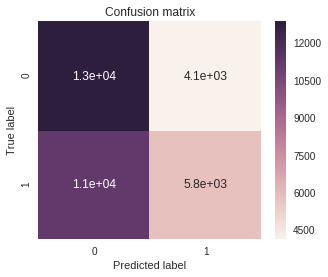

In [58]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score

plt.figure(figsize = (5,4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True)
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

print(classification_report(y_test, y_pred))
print("accuracy score: ", accuracy_score(y_test, y_pred))


AUC:  0.548051190756


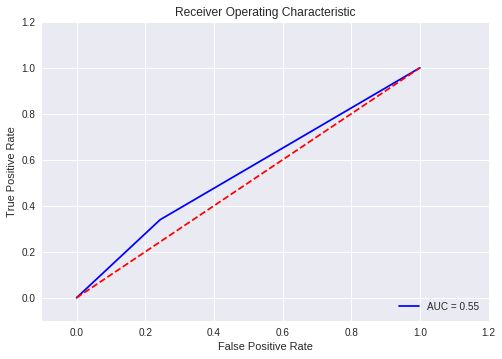

In [59]:
####ROC curve 
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

print("AUC: ", roc_auc)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Okay, so the model results are slightly better than a coin toss.  At least we got some practice using on our ML workflow!